<a href="https://colab.research.google.com/github/AzitaKalantar/NLP-Projects/blob/main/Sentiment%20and%20Emotion%20Detector%20using%20ISEAR%20dataset/version1_Embedding_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Building an Emotion Classifier Model

Extracting Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
train_data = pd.read_csv('drive/My Drive/Data/ISEAR/data_train.csv')
test_data = pd.read_csv('drive/My Drive/Data/ISEAR/data_test.csv')

In [3]:
train_data.columns = ["Emotion","Text"]
test_data.columns = ["Emotion","Text"]
print(train_data.head())
print(test_data.head())

   Emotion                                               Text
0  neutral   There are tons of other paintings that I thin...
1  sadness  Yet the dog had grown old and less capable , a...
2     fear  When I get into the tube or the train without ...
3     fear  This last may be a source of considerable disq...
4    anger  She disliked the intimacy he showed towards so...
   Emotion                                               Text
0  sadness  I experienced this emotion when my grandfather...
1  neutral   when I first moved in , I walked everywhere ....
2    anger  ` Oh ! " she bleated , her voice high and rath...
3     fear  However , does the right hon. Gentleman recogn...
4  sadness  My boyfriend didn't turn up after promising th...


Data Cleaning and Preprocessing

In [4]:
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.stem import PorterStemmer

In [5]:
def preprocess_data(data):
  #make the text lower case
  data['Text'] = data['Text'].apply(lambda a: " ".join(a.lower() for a in a.split()))
  #remove non-word characters (^\w) or white space characters (\s)
  data['Text'] = data['Text'].apply(lambda a: " ".join(a.replace('[^\w\s]','') for a in a.split()))
  #remove stop words
  stop = stopwords.words('english')
  data['Text'] = data['Text'].apply(lambda a: " ".join(a for a in a.split() if a not in stop))
  #correct spelling
  data['Text'] = data['Text'].apply(lambda a: str(TextBlob(a).correct()))
  #do stemming
  st = PorterStemmer()
  data['Text'] =  data['Text'].apply(lambda a: " ".join([st.stem(word) for word in a.split()]))
  return data


In [ ]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)
print(train_data.head())
print(test_data.head())

In [ ]:
train_data.to_csv("drive/My Drive/Data/ISEAR/pre_processsed_data_train.csv")
test_data.to_csv("drive/My Drive/Data/ISEAR/pre_processsed_data_test.csv")

In [7]:
import pandas as pd
train_data = pd.read_csv('drive/My Drive/Data/ISEAR/pre_processsed_data_train.csv')
test_data = pd.read_csv('drive/My Drive/Data/ISEAR/pre_processsed_data_test.csv')
train_data.drop(train_data.columns[0],axis=1)
test_data.drop(test_data.columns[0],axis=1)

,Emotion,Text
0,sadness,experienc emot grandfath pass away.
1,neutral,"first move , walk everywher . within week , pu..."
2,anger,"` oh ! "" belat , voic high rather indign ."
3,fear,"howev , right hon. gentleman recognis profound..."
4,sadness,boyfriend turn promis coming.
...,...,...
3388,sadness,"sweetheart left me, rather decid break mutual ..."
3389,sadness,"well , bad like differ kind move . mayb we'r d..."
3390,neutral,sure .
3391,sadness,’ got laid . feel sorri .


Data Sience :

Build vocabulary, vectorize and Data set and classifier classes

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [9]:
#the main vocabulary class job : creates a token to index and a index to token dictionary. we can access to one of each, given the other
class Vocabulary(object):
  def __init__(self,data=None,add_unk = True,unk_token = "<UNK>",add_mask = True,mask_token="<MASK>"):
    self.token_to_index = {}
    self.index_to_token = {}
    #mask and unk tokens are optional depending on the vocabulary and the problem
    self.add_unk = add_unk
    if add_unk :
      self.unk_token = unk_token
      self.add_token(unk_token)
      self.unk_index = self.token_to_index[unk_token]
    if add_mask:
      self.add_token(mask_token)
      self.mask_index = self.token_to_index[mask_token]
    if data.empty == False :
      for row in data :
        for token in row.split():
          self.add_token(token)

  #this function gets one token and add it to the dictionary by updating both token_to_index and index_to_token      
  def add_token(self,token):
    if token not in self.token_to_index :
      next_index_in_vocab = len(self.token_to_index)
      self.token_to_index[token] = next_index_in_vocab
      self.index_to_token[next_index_in_vocab] = token
  # this function search for a token and returns its corresponding token, if the token is not in the vocabulary and vocabulary supports 
  # unk tokens it returns the index of unk token, otherwise it raise an error 
  def lookup_token(self,token):
    if self.add_unk:
      return self.token_to_index.get(token,self.unk_index)
    else :
      return self.token_to_index[token]
  # this function search for a index and returns its corresponding token
  def lookup_index(self,index):
    return self.index_to_token[index]

  # returns the legth of the vocabulary
  def __len__(self):
    return len(self.token_to_index)

  def use_previous_token_to_index(self,token_to_index):
    self._token_to_idx = token_to_index
    self.index_to_token = {idx: token for token, idx in self.token_to_index.items()}

In [10]:
#the main job of Vectorizer class: it is responsible for converting a text (sequence of tokens) to a vectorized version of it (sequence of indexes)
#so it can be used by neural network layers

class Vectorizer(object):
  def __init__(self,text_vocab,emotion_vocab):
    self.text_vocab = text_vocab
    self.emotion_vocab = emotion_vocab
  #vector_length is usually the lentgh of the maximum text
  #although we have textes with different lengthes but we neet  put them in a fixed-size vector and fill the remaining of the vector with mask
  #tokens. I also return the actual length of each text
  def vectorize(self,text,vector_length):
    indices = [self.text_vocab.lookup_token(token) for token in text.split(' ')]
    out_vector = np.zeros(vector_length, dtype=np.int64)
    out_vector[:len(indices)] = indices
    out_vector[len(indices):] = self.text_vocab.mask_index
    return out_vector,len(indices)


In [11]:
#The main job of Dataset class : Dataset class inherits from Dataset class in pytorch and implements two essential funtions of it, __getitem()__
#and __len__(), this class in being used for getting the dataset rows (vectorized version) during training and testing 
class Dataset(Dataset):
  def __init__(self,dataframe,vectorizer):
    self.dataframe = dataframe
    self.vectorizer = vectorizer
    measure_len = lambda text: len(text.split(" "))
    self._max_text_length = max(map(measure_len, dataframe.Text))

    # Class weights
    class_counts = self.dataframe.Emotion.value_counts().to_dict()
    def sort_key(item):
        return self.vectorizer.emotion_vocab.lookup_token(item[0])
    sorted_counts = sorted(class_counts.items(), key=sort_key)
    frequencies = [count for _, count in sorted_counts]
    self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

  def __getitem__(self,index) :
      row = self.dataframe.iloc[index]
      vectorized_text,length_text = self.vectorizer.vectorize(row.Text, self._max_text_length)
      target_index = self.vectorizer.emotion_vocab.lookup_token(row.Emotion)
      #we return the vectoized version of text as x, and the index of emotion as y we also return the actual length of the text
      return {'x_data': vectorized_text,
              'y_target': target_index,
              "x_length" : length_text
              }
  def __len__(self):
    return len(self.dataframe)

In [12]:
#column gather function gets a set of outputs (of RNN cell) and returns the one after t = seeing last token in the text
def column_gather(y_out, x_lengths):

    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])
    return torch.stack(out)

#main job of classifier class : it inherits from the Module class in pytorch and implements a forward function, it builds the structure of the
#neural network model and is being used for doing forward pass in training process
class EmotionClassifier(nn.Module):
  def __init__(self,num_classes, text_vocab_size,embedding_size,rnn_hidden_size,pretrained_embeddings=None,padding_idx=0,dropout_p=0.5):
    super(EmotionClassifier, self).__init__()
    if pretrained_embeddings is None :
      # I created an embedding layer to convert each token to a an ambedded vector. Embedded vecores are being created and tuned during the
      # training process. embedding_dim is an arbitary size that we want to have for each embedded token.
      self.word_emb = nn.Embedding(num_embeddings=text_vocab_size,
                                      embedding_dim=embedding_size,
                                      padding_idx=padding_idx)
    else :
      pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float() 
      self.word_emb = nn.Embedding(num_embeddings=text_vocab_size,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx,
                                _weight=pretrained_embeddings)
    #GRU is a sequential nerural network layer which generates outputs by using a sequense of inputes and its hidden layer. at each time step 
    #(seeing one token), it also updates its hidden layer. hidden_size is an arbitary output size for GRU layer
    self.rnn = nn.GRU(input_size=embedding_size,
                          hidden_size=rnn_hidden_size,
                          batch_first=True)

    self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                      out_features=rnn_hidden_size)
    self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                      out_features=num_classes)
  
  def forward(self,x_in,apply_softmax=False,x_lengths=None):
        # we tranfer indexes to embedded vectores
        x_embedded = self.word_emb(x_in)
        # we use our rnn layer and get a sequence of outputs, each one corresponding to one time step
        y_out, _ = self.rnn(x_embedded)

        #if x_lengths is providede we select the output of rnn cell which was provided after seeing the last token in the test
        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        #otherwise we select the last ouput (real tokens + mask tokens)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(y_out))
        y_out = self.fc2(F.dropout(y_out, 0.3))
        #soft mask is better to be used just for testing and not during training proceess (makes some mathmatical difficulities with our 
        #cross entropy loss function)
        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out


Initializing and Tranining

In [13]:
#a function for loading the pretained embedings (glove embeddings is this case)
def load_glove_from_file(glove_filepath):

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, "r") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0]
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)
#this function uses the function above and creates an embedding matrix for the words that we have in our vocabulary
#this matrix is being used as weights for our Embeddings layer in the classifier
def make_embedding_matrix(glove_filepath, words):

    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            #if there is a word in out vocabulary which is not in the glove dataset, we use a uniformely distributed data as the embedding
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i
    return final_embeddings
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

batch_size=16
learning_rate=5e-04
num_epochs=10
seed=1376
embedding_size=100
rnn_hidden_size=200
val_ratio = 0.15

In [14]:
if not torch.cuda.is_available():
    cuda = False
    device = torch.device("cpu")
else :
    cuda = True
    device = torch.device("cuda")
print("Using CUDA: {}, device : {}".format(cuda,device))
set_seed_everywhere(seed,cuda)

Using CUDA: True, device : cuda


In [15]:
#splitting the training data into train and validation data
val_ratio = 0.15
val_data = pd.DataFrame(columns = ["Text","Emotion"])
for label in train_data.Emotion.unique():
      val_df  = train_data[train_data["Emotion"] == label].sample(frac = val_ratio)
      val_data =pd.concat([val_data, val_df], axis=0)


train_data = train_data[~train_data.loc[:,["Text","Emotion"]].index.isin(val_data.loc[:,["Text","Emotion"]].index)]

Loading dataset and creating vectorizer

In [16]:
# we should build the vocabularies and the vectorizer just using our trainig data
emotion_vacob = Vocabulary(train_data.Emotion,add_unk = False,add_mask = False)
text_vocab = Vocabulary(train_data.Text,add_unk = True) 
vectorizer = Vectorizer(text_vocab,emotion_vacob)
#making train, validation and test  validation datastes
val_dataset = Dataset(val_data,vectorizer)
train_dataset = Dataset(train_data,vectorizer)
test_dataset = Dataset(test_data,vectorizer)
#we use a pretained embeddings dataset (glove) as the initial weights of our Embedding layer in the classifier
words = text_vocab.token_to_index.keys()
embeddings = make_embedding_matrix(glove_filepath="/content/drive/My Drive/Data/ISEAR/glove.6B.100d.txt", words=words)


In [17]:
classifier = EmotionClassifier(text_vocab_size=len(text_vocab),num_classes=len(emotion_vacob),embedding_size=embedding_size,
                               rnn_hidden_size=rnn_hidden_size,pretrained_embeddings=embeddings)



In [18]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [19]:
train_dataset.class_weights = train_dataset.class_weights.to(device)
loss_func = nn.CrossEntropyLoss(train_dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,drop_last=True)


In [20]:
classifier = classifier.to(device)
train_loss= []
train_acc = []
val_loss= []
val_acc = []
smalles_loss = float('inf')
for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  classifier.train()
  for batch_index, batch_dict in enumerate(train_dataloader):

    for name, tensor in batch_dict.items():
      batch_dict[name] = batch_dict[name].to(device)

    #zero the gradients
    optimizer.zero_grad()

    #compute the output
    y_pred = classifier(x_in=batch_dict['x_data'], 
                        x_lengths=batch_dict['x_length'])

    #compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])

    running_loss += (loss.item() - running_loss) / (batch_index + 1)

    #use loss to produce gradients
    loss.backward()

    #use optimizer to take gradient step
    optimizer.step()
    
    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)
    
  train_loss.append(running_loss)
  train_acc.append(running_acc)

  running_loss = 0.
  running_acc = 0.
  classifier.eval()
  for batch_index, batch_dict in enumerate(val_dataloader):

    for name, tensor in batch_dict.items():
      batch_dict[name] = batch_dict[name].to(device)

    #compute the output
    y_pred = classifier(x_in=batch_dict['x_data'], 
                        x_lengths=batch_dict['x_length'])

    #compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])

    running_loss += (loss.item() - running_loss) / (batch_index + 1)
    
    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)
  
  val_loss.append(running_loss)
  val_acc.append(running_acc)
  #saving the best model we have so far
  if running_loss < smalles_loss :
    torch.save(classifier.state_dict(),"drive/My Drive/Data/ISEAR/model")
    smalles_loss = running_loss

  scheduler.step(running_loss)





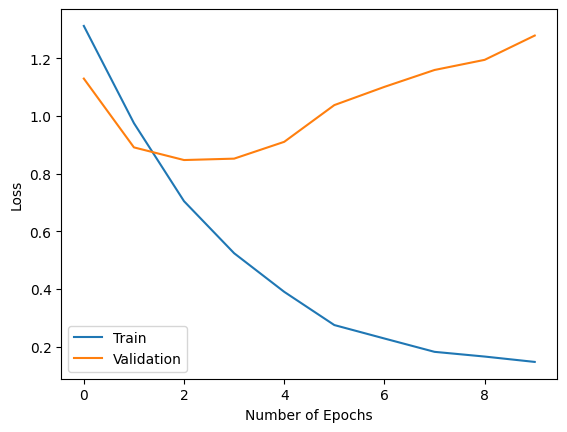

In [21]:
import matplotlib.pyplot as plt
plot1, = plt.plot(train_loss)
plot2, = plt.plot(val_loss)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend([plot1,plot2],["Train", "Validation"])
plt.show()

In [22]:
# we load the best model we had during training process
classifier.load_state_dict(torch.load("drive/My Drive/Data/ISEAR/model"))

<All keys matched successfully>

In [23]:
test_running_loss = 0.0
test_running_acc = 0.0
classifier.eval()

for batch_index, batch_dict in enumerate(test_dataloader):

  for name, tensor in batch_dict.items():
      batch_dict[name] = batch_dict[name].to(device)

  # compute the output
  y_pred =  classifier(batch_dict['x_data'],
                        x_lengths=batch_dict['x_length'])
  
  # compute the loss
  loss = loss_func(y_pred, batch_dict['y_target'])
  loss_t = loss.item()
  test_running_loss += (loss_t - test_running_loss) / (batch_index + 1)

  # compute the accuracy
  acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
  test_running_acc += (acc_t - test_running_acc) / (batch_index + 1)


In [24]:
print("test loss : {}, test accuracy : {}".format(test_running_loss,test_running_acc))

test loss : 0.8641165402138008, test accuracy : 68.36674528301887


To be able to use the trained model later, it is important to save the text vocabulary we built from the training data, it will be used for generating vectorizers

In [25]:
import json

vocabs = {'text_vocab': text_vocab.token_to_index}
with open("drive/My Drive/Data/ISEAR/vocabs.json", "w") as fp:
  json.dump(vocabs, fp)


Inference

In [26]:
def predict_emotion(Text, classifier, vectorizer, max_length):
    vectorized_text,_ = vectorizer.vectorize(Text, vector_length=max_length)
    vectorized_text = torch.tensor([vectorized_text]).to(device)
    result = classifier(vectorized_text, apply_softmax=True)
    probability_values, indices = result.max(dim=1)
    predicted_emotion = vectorizer.emotion_vocab.lookup_index(indices.item())

    print({'Emotion': predicted_emotion, 'probability': probability_values.item()})

In [27]:
predict_emotion("I feel good",classifier,vectorizer,3)

{'Emotion': 'sadness', 'probability': 0.41656380891799927}


<ipython-input-26-c4339d3b816a>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  vectorized_text = torch.tensor([vectorized_text]).to(device)


In [28]:
predict_emotion("I feel bad",classifier,vectorizer,3)

{'Emotion': 'sadness', 'probability': 0.6172960996627808}


In [29]:
predict_emotion("I feel nervous",classifier,vectorizer,3)

{'Emotion': 'fear', 'probability': 0.5140637159347534}
